# 3D prediction full deposit

In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
#two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)
two_composite_filtered = pd.read_csv("Curated_data/cluster_0_data.csv", low_memory=False)

C:\Users\23478671\AppData\Local\Temp\ipykernel_15276\1044243622.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_15276\1044243622.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_15276\1044243622.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

- Iteration 0, MSE: 0.0052
- Iteration 100, MSE: 0.0030
- Iteration 200, MSE: 0.0028
- Iteration 300, MSE: 0.0027
- Iteration 400, MSE: 0.0026
- Iteration 500, MSE: 0.0025
- Iteration 600, MSE: 0.0024
- Iteration 700, MSE: 0.0024


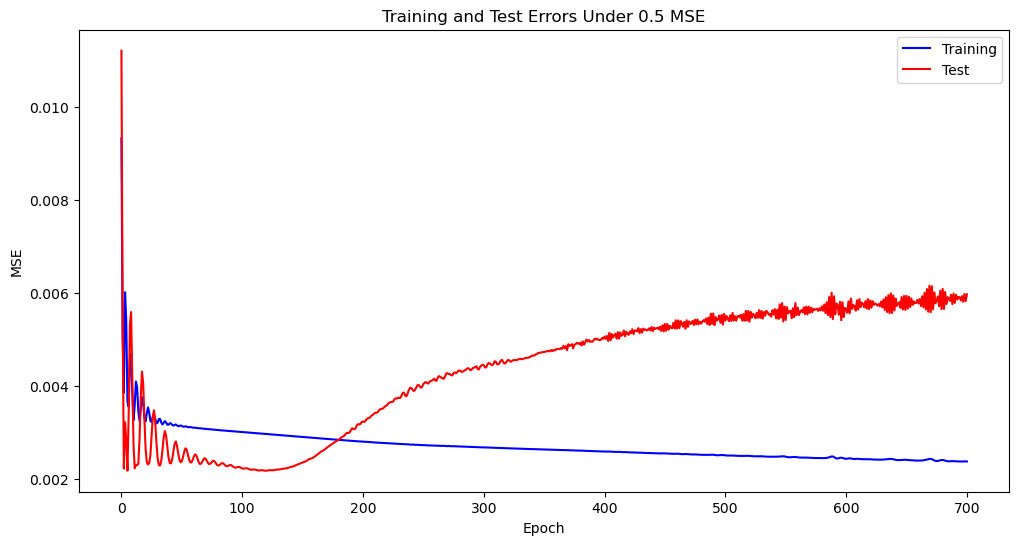

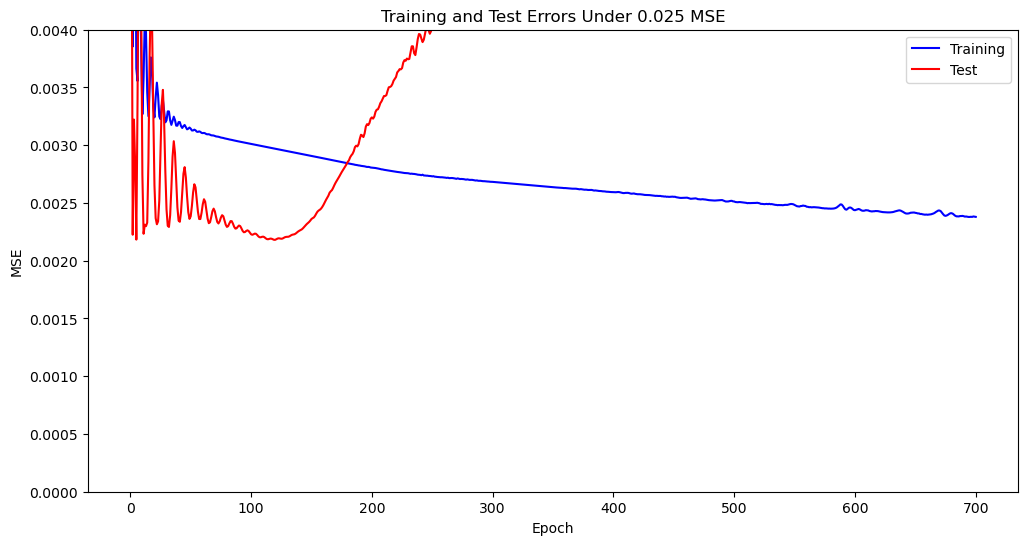

In [4]:


mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
deposit_data = two_composite_1mineral.dropna(subset=[mineral])
    
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
deposit_data.loc[:, [mineral]] = scaler.fit_transform(deposit_data.loc[:, [mineral]])

x = deposit_data[['X', 'Y', 'Z']].values  # Use X, Y, and Z coordinates
y = deposit_data[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(deposit_data), 3)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X', 'Y', 'Z']].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


model = nn.Sequential(
    nn.Linear(in_features=3, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1),
    nn.Sigmoid()
)

mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(701):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.004)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()


# ... (previous code for data preprocessing)

# Define a grid of points for prediction (including X, Y, and Z)
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 50)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 50)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 50)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(50, 50, 50)

# Create a 3D surface plot using Plotly

# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='viridis',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]

)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_test.data.numpy().ravel(),
        colorscale='viridis',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y_test.data.numpy().ravel()]

))



fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
#fig.write_html('tmp.html', auto_open=True)
#fig.show()




In [5]:
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 50)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 50)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 50)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(50, 50, 50)

# Create a 3D surface plot using Plotly

# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

## Plot of predictions + entire data

In [6]:
# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)

fig.write_html('tmp.html', auto_open=True)



## Plot of predictions + test set

In [ ]:
# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_test.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)

fig.show()

## Plot of predictions + train set

In [ ]:
x_points = 100
y_points = 100
z_points = 100

x_grid2 = np.linspace(x[:, 0].min(), x[:, 0].max(), x_points)
y_grid2 = np.linspace(x[:, 1].min(), x[:, 1].max(), y_points)
z_grid2 = np.linspace(x[:, 2].min(), x[:, 2].max(), z_points)
xyz_grid2 = np.array(np.meshgrid(x_grid2, y_grid2, z_grid2)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid2, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(x_points, y_points, z_points)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0], y_train.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

step_titles = ["Predictions", "Test Set", "Train Set"]

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid2[:,0],
    y=xyz_grid2[:,1],
    z=xyz_grid2[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_train.data.numpy()[:, 0],
    y=x_train.data.numpy()[:, 1],
    z=x_train.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_train.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y_train.data.numpy().ravel()]

))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
fig.write_html('tmp.html', auto_open=True)
#fig.show()


## Showing different planes

In [ ]:
x_points = 100
y_points = 100
z_points = 100

x_grid2 = np.linspace(x[:, 0].min(), x[:, 0].max(), x_points)
y_grid2 = np.linspace(x[:, 1].min(), x[:, 1].max(), y_points)
z_grid2 = np.linspace(x[:, 2].min(), x[:, 2].max(), z_points)
xyz_grid2 = np.array(np.meshgrid(x_grid2, y_grid2, z_grid2)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid2, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(x_points, y_points, z_points)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0], y_train.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

step_titles = ["Predictions", "Test Set", "Train Set"]

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid2[:,0],
    y=xyz_grid2[:,1],
    z=xyz_grid2[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y.data.numpy().ravel()]

))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
fig.write_html('tmp.html', auto_open=True)
#fig.show()


## Export to CSV

In [ ]:
# import pandas as pd
# import numpy as np

# # Assuming you already have the variables xyz_grid and predictions

# # Create a DataFrame with xyz_grid and predictions
# df = pd.DataFrame({'X': xyz_grid[:, 0].ravel(), 
#                    'Y': xyz_grid[:, 1].ravel(), 
#                    'Z': xyz_grid[:, 2].ravel(), 
#                    'Predictions': predictions.ravel()})

# # Display the DataFrame
# print(df)

# # Assuming you have the DataFrame named 'df'

# # Specify the file path for the CSV file
# csv_file_path = 'xyz_predictions.csv'

# # Export the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)

# print(f'DataFrame has been exported to {csv_file_path}')


## With Buttons

In [ ]:
x_points = 100
y_points = 100
z_points = 100

x_grid2 = np.linspace(x[:, 0].min(), x[:, 0].max(), x_points)
y_grid2 = np.linspace(x[:, 1].min(), x[:, 1].max(), y_points)
z_grid2 = np.linspace(x[:, 2].min(), x[:, 2].max(), z_points)
xyz_grid2 = np.array(np.meshgrid(x_grid2, y_grid2, z_grid2)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid2, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(x_points, y_points, z_points)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0], y_train.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

step_titles = ["Predictions", "Train Set", "Test Set"]

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid2[:,0],
    y=xyz_grid2[:,1],
    z=xyz_grid2[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_train.data.numpy()[:, 0],
    y=x_train.data.numpy()[:, 1],
    z=x_train.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_train.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y_train.data.numpy().ravel()]

))

fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_test.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y_test.data.numpy().ravel()]

))

# ... (your existing code for creating the scatter plot)

# Define initial visibility states
visibility_states = [True, False, False]  # Initially show predictions only

# Create buttons for showing/hiding train, test, and predictions
buttons = []

button_labels = ["Show Predictions", "Show Train Set", "Show Test Set"]
button_visibility_settings = [
    [True, False, False],
    [False, True, False],
    [False, False, True],
]

for label, visibility_settings in zip(button_labels, button_visibility_settings):
    button = dict(
        label=label,
        method="restyle",
        args=[{"visible": visibility_settings}, {"title": label}],
    )
    buttons.append(button)

# Add dropdown buttons for showing/hiding components
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            type="dropdown",
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top",
        )
    ]
)

fig.write_html('tmp.html', auto_open=True)
